# Notes
* Use random_state = 0 whenever possible
* Avoid Run All since some chuncks will take very long time to run 
* You can store datasets and trained models in a public Github respoitory and load them from there
*  When you connect to a GPU (this is the case for this notebook), you are given a maximum of 12 hours at a time on the Cloud Machine

# Packages install and import chunk below
* Comment what that package is for better organization

In [44]:
!pip install rdkit-pypi 
!pip install --pre deepchem 
# !pip install biokit 
!pip install pickle

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1125)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1125)'))) - skipping
Could not fetch URL https://pypi.org/simple/pickle/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pickle/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CER

ERROR: Could not find a version that satisfies the requirement pickle
ERROR: No matching distribution found for pickle


In [45]:
%%capture 
#run the cell, capturing stdout, stderr, and IPython’s rich display() calls

#Basics
import numpy as np
import pandas as pd #Basic dataframe package

#Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
# from biokit.viz import corrplot #For checking correlations between descriptors


#Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import Chem
from rdkit.Chem import Descriptors #Generate a dataframe of descriptors from SMILES
# import deepchem as dc

#Data preprocessing 
# import imblearn #For imbalanced data. Use class weight first before you throw out data or generate artificial data 
from sklearn.model_selection import train_test_split #For the hold-out method 
from sklearn.preprocessing import StandardScaler #For scaling, which is reuiqred by SVM
from sklearn.feature_selection import VarianceThreshold #For checking descriptors with low variance 
from sklearn.decomposition import PCA #For feature engineering 

#Models
import sklearn
from sklearn.model_selection import train_test_split  #For cross-validation
from sklearn.model_selection import StratifiedKFold #For stratified cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold #For repeated stratified cross-validation
from sklearn.model_selection import GridSearchCV #For hyperparameter tuning
from sklearn.model_selection import ParameterGrid #For hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier #For GBM 
from sklearn.ensemble import StackingClassifier #For ensemble learning, specifically in a stacking style. If you want the voting style, you can use VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import clone #Use to duplicate a model. This is necessary since best_estimator_.set_params(**temp_model_params) will change all unless you make a clone. Once you have a clone, you still need to train it by fit()

#For saving the intermediate files for later uses 
# import pickle5 as pickle #Must use pickle5 for Google colab 
import pickle
import cloudpickle as cp
from urllib.request import urlopen

#Evaluations
from sklearn.metrics import make_scorer #This makes scorer to be used as part of the scoring parameter for GridSearchCV
from sklearn.metrics import matthews_corrcoef #MCC
from sklearn.metrics import recall_score #Recall
from sklearn.metrics import roc_auc_score #AUC

# Self-defined functions

In [46]:
def dump_pickle(content_to_dump, pickle_name_str): #Dump the content_to_dump into a pickle. Remember to include ".pkl" in pickle_name_str
  cp.dump(content_to_dump, open(pickle_name_str, 'wb')) #Save the GridSearchCV object to be used later
  return

def load_cloud_pickle(github_url): #Load pickles (contain trained models) from a GitHub link
  url_raw_file=github_url+'?raw=true'
  loaded_pickle_object = pickle.load(urlopen(url_raw_file)) 
  return loaded_pickle_object

# Anti-SARS-CoV-2 screening
* To avoid conflict on variable names, all the variables used in this section will have a suffix "i" for inhibitor.

# Phospholipidosis
* The goal of this section is to train a decient classifier that can predict whether a molecule is phospholipidosis-inducing. It does not have to be perfect since this is not the major focus of our project.
* Since the phospholipidosis dataset is very small, I only picked models that are relatively simple--RF, GBM, and SVM. Deep learning models are excluded since they tend to get crazy on small datatsets. Extremely simple models like linear regression are also excluded for better performance. 
* Although both RF and GBM can output feature importances, SVM's input features are selected in a different manner. This is because these 3 models will be rather parallel base-level models for the meta learner. If the SVM is trained by the features that RF and/or GBM think are important, then probably SVM will perform very similarly to the RF and GBM, which will lost the purpose of the ensemble learning scheme. 
* All the options for hyperparameter tunning are either exactly the same or the used ones in the original literature or a subset of those due to the limitation of calculational power available to me. 
* All the GridSearchCV results will be stored in GitHub and further analysis will go from there. 

## Read the original data 

In [47]:
ppl_df=pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/RawData/ppl.csv?raw=true') #This is the .csv file for phospholipidosis
ppl_df

,Name,Smiles,PPL
0,AC-3579,O=N2=C4C3=C(N=C2CN1CCN(C)CC1)C=CC=C3C5=C4C=CC=C5,Pos
1,Acetaminophen,O=C(C)NC1=CC=C(O)C=C1,Neg
2,Amikacin,O(C2C(N)CC(NC(=O)C(O)CCN)C(OC1OC(CO)C(O)C(N)C1...,Pos
3,Amiodarone,IC3=C(OCCN(CC)CC)C(I)=CC(C(=O)C1C2=C(OC=1CCCC)...,Pos
4,Amitriptyline,N(C)(C)CCC=C2C1=C(C=CC=C1)CCC3=C2C=CC=C3,Pos
...,...,...,...
180,Thioridazine,S(C)C3=CC=C2SC4=C(N(CCC1N(C)CCCC1)C2=C3)C=CC=C4,Pos
181,Trimipramine,N(C)(C)CC(C)CN2C1=C(C=CC=C1)CCC3=C2C=CC=C3,Pos
182,Tripelennamine,N(C)(C)CCN(C1=NC=CC=C1)CC2=CC=CC=C2,Pos
183,Trospectomycin-sulfate,O2C(CCCC)CC(=O)C3(O)OC1C(NC)C(O)C(NC)C(O)C1OC23,Pos


In [48]:
ppl_df.shape #You should have 185 molecules

(185, 3)

In [49]:
ppl_df['PPL'].value_counts() #Slightly imbalanced

Pos    102
Neg     83
Name: PPL, dtype: int64

## Data preprocessing

### Numerize the label column 
* 0 (for Neg) and 1 (for Pos) 

In [50]:
ppl_df['PPL']=np.where(ppl_df['PPL']=='Pos',1,0)
ppl_df

,Name,Smiles,PPL
0,AC-3579,O=N2=C4C3=C(N=C2CN1CCN(C)CC1)C=CC=C3C5=C4C=CC=C5,1
1,Acetaminophen,O=C(C)NC1=CC=C(O)C=C1,0
2,Amikacin,O(C2C(N)CC(NC(=O)C(O)CCN)C(OC1OC(CO)C(O)C(N)C1...,1
3,Amiodarone,IC3=C(OCCN(CC)CC)C(I)=CC(C(=O)C1C2=C(OC=1CCCC)...,1
4,Amitriptyline,N(C)(C)CCC=C2C1=C(C=CC=C1)CCC3=C2C=CC=C3,1
...,...,...,...
180,Thioridazine,S(C)C3=CC=C2SC4=C(N(CCC1N(C)CCCC1)C2=C3)C=CC=C4,1
181,Trimipramine,N(C)(C)CC(C)CN2C1=C(C=CC=C1)CCC3=C2C=CC=C3,1
182,Tripelennamine,N(C)(C)CCN(C1=NC=CC=C1)CC2=CC=CC=C2,1
183,Trospectomycin-sulfate,O2C(CCCC)CC(=O)C3(O)OC1C(NC)C(O)C(NC)C(O)C1OC23,1


### Molecular descriptors generation

In [51]:
descriptors_list = [x[0] for x in Descriptors._descList] #This is a list of simple descriptors to be calculated

calc=MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)

descriptor_list=[]
descriptor_list.append(descriptors_list)
for index, row in ppl_df.iterrows():
  smiles=row['Smiles']
  mol = Chem.MolFromSmiles(smiles)
  individual_list=list(calc.CalcDescriptors(mol))
  descriptor_list.append(individual_list)
  
descriptor_df=pd.DataFrame(descriptor_list)

new_header = descriptor_df.iloc[0] #grab the first row for the header
descriptor_df = descriptor_df[1:] #take the data less the header row
descriptor_df.columns = new_header #set the header row as the df header

descriptor_df=descriptor_df.reset_index(drop=True) #Reset the indexes for all the rows and drop the old index column 
descriptor_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.165138,0.598061,13.165138,0.598061,0.417237,332.407,312.247,332.163711,126,0,...,0,0,0,0,0,0,0,0,0,0
1,10.524469,-0.115102,10.524469,0.115102,0.595026,151.165,142.093,151.063329,58,0,...,0,0,0,0,0,0,0,0,0,0
2,12.578431,-1.755831,12.578431,0.010081,0.113064,585.608,542.264,585.285736,234,0,...,0,0,0,0,0,0,0,0,0,0
3,13.588032,0.015348,13.588032,0.015348,0.167647,645.319,616.087,645.02369,166,0,...,0,0,0,0,0,0,0,0,0,0
4,2.41963,1.088296,2.41963,1.088296,0.813678,277.411,254.227,277.18305,108,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.562827,0.724699,2.562827,0.724699,0.619208,370.587,344.379,370.153741,132,0,...,1,0,0,0,0,0,0,0,0,0
181,2.533565,0.619641,2.533565,0.619641,0.836647,294.442,268.234,294.209599,116,0,...,0,0,0,0,0,0,0,0,0,0
182,4.460591,0.894537,4.460591,0.894537,0.790803,255.365,234.197,255.173548,100,0,...,0,0,0,0,0,0,0,0,0,0
183,12.584147,-2.231249,12.584147,0.043864,0.38009,374.434,344.194,374.205301,150,0,...,0,0,0,0,0,0,0,0,0,0


### Add in the Structural alerts (SA)

In [52]:
sa_df=pd.read_csv('https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/RawData/ppl_sa.csv?raw=true')
sa_df.drop(columns=['MOLECULEID','SMILES'],inplace=True)
sa_df

,TA328,TA345,TA375,TA376,TA534,TA919,TA926,TA968,TA994,TA1058,...,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
descriptor_df=pd.concat([descriptor_df, sa_df], axis=1) #Exclude the 'SMILES' column from the sa_df since it cannot be part of the feature dataset
descriptor_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,13.165138,0.598061,13.165138,0.598061,0.417237,332.407,312.247,332.163711,126,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.524469,-0.115102,10.524469,0.115102,0.595026,151.165,142.093,151.063329,58,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.578431,-1.755831,12.578431,0.010081,0.113064,585.608,542.264,585.285736,234,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.588032,0.015348,13.588032,0.015348,0.167647,645.319,616.087,645.02369,166,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.41963,1.088296,2.41963,1.088296,0.813678,277.411,254.227,277.18305,108,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.562827,0.724699,2.562827,0.724699,0.619208,370.587,344.379,370.153741,132,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,2.533565,0.619641,2.533565,0.619641,0.836647,294.442,268.234,294.209599,116,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,4.460591,0.894537,4.460591,0.894537,0.790803,255.365,234.197,255.173548,100,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,12.584147,-2.231249,12.584147,0.043864,0.38009,374.434,344.194,374.205301,150,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add in the label column 

In [54]:
descriptor_df['Y']=ppl_df['PPL'] #Concatenate the new descriptor dataframe with Y column of the original drug dataframe
descriptor_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297,Y
0,13.165138,0.598061,13.165138,0.598061,0.417237,332.407,312.247,332.163711,126,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.524469,-0.115102,10.524469,0.115102,0.595026,151.165,142.093,151.063329,58,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,12.578431,-1.755831,12.578431,0.010081,0.113064,585.608,542.264,585.285736,234,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,13.588032,0.015348,13.588032,0.015348,0.167647,645.319,616.087,645.02369,166,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2.41963,1.088296,2.41963,1.088296,0.813678,277.411,254.227,277.18305,108,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.562827,0.724699,2.562827,0.724699,0.619208,370.587,344.379,370.153741,132,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
181,2.533565,0.619641,2.533565,0.619641,0.836647,294.442,268.234,294.209599,116,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
182,4.460591,0.894537,4.460591,0.894537,0.790803,255.365,234.197,255.173548,100,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
183,12.584147,-2.231249,12.584147,0.043864,0.38009,374.434,344.194,374.205301,150,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Cleaning

In [55]:
print('Before cleaning, you have', len(descriptor_df),'datapoints')
descriptor_df=descriptor_df.dropna() #By default, dropna(axis=0) which means drop rows which contain missing values
print('After cleaning, you have', len(descriptor_df),'datapoints')
descriptor_df

Before cleaning, you have 185 datapoints
After cleaning, you have 185 datapoints


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297,Y
0,13.165138,0.598061,13.165138,0.598061,0.417237,332.407,312.247,332.163711,126,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,10.524469,-0.115102,10.524469,0.115102,0.595026,151.165,142.093,151.063329,58,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,12.578431,-1.755831,12.578431,0.010081,0.113064,585.608,542.264,585.285736,234,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,13.588032,0.015348,13.588032,0.015348,0.167647,645.319,616.087,645.02369,166,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2.41963,1.088296,2.41963,1.088296,0.813678,277.411,254.227,277.18305,108,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,2.562827,0.724699,2.562827,0.724699,0.619208,370.587,344.379,370.153741,132,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
181,2.533565,0.619641,2.533565,0.619641,0.836647,294.442,268.234,294.209599,116,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
182,4.460591,0.894537,4.460591,0.894537,0.790803,255.365,234.197,255.173548,100,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
183,12.584147,-2.231249,12.584147,0.043864,0.38009,374.434,344.194,374.205301,150,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [56]:
#These are the full data 
whole_descriptor_df_X=descriptor_df.loc[:, descriptor_df.columns != 'Y']
whole_descriptor_df_y=descriptor_df['Y']

### Hold-out method to have the real test set 
* This will be used as completely unknown data to prevent overfitting

In [57]:
ppl_X_train, ppl_X_test, ppl_y_train, ppl_y_test = train_test_split(whole_descriptor_df_X, whole_descriptor_df_y, 
                                                                    test_size=0.2, 
                                                                    stratify=whole_descriptor_df_y, #Stratified split
                                                                    random_state=0)

descriptor_df_X=ppl_X_train
descriptor_df_y=ppl_y_train

## Support vector machine (SVM) training

### Feature scaling
* Required by SVM

In [58]:
svm_scaler=StandardScaler()
descriptor_df_X_scaled_array=svm_scaler.fit_transform(descriptor_df_X) #fit_transform outputs an array and it will lost the feature names (column headers)

descriptor_df_X_scaled=pd.DataFrame(descriptor_df_X_scaled_array,columns=descriptor_df_X.columns) #Remake the df for the transformed data from the array and add back the columns

descriptor_df_X_scaled
#Each feature's Gaussian distribution is now centered around 0 and it's standard deviation is 1

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA314,TA2560,TA2561,TA10297
0,-1.083245,0.801723,-1.083245,0.353553,-1.379053,0.793896,0.675447,0.794872,1.015553,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
1,-1.867874,1.142799,-1.867874,1.611672,1.190778,-0.477043,-0.501165,-0.476134,-0.410209,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
2,1.202414,-1.174772,1.202414,-0.382100,-1.880568,1.163536,1.169580,1.164841,1.247653,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
3,0.226996,-0.049411,0.226996,-0.495114,-0.336946,-0.116391,-0.063728,-0.118636,-0.310737,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
4,0.252887,0.467190,0.252887,-0.589046,0.842434,-1.024575,-1.022881,-1.023550,-0.973882,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.631941,-0.070090,0.631941,0.740762,0.734095,0.277953,0.274866,0.278011,0.153464,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
144,0.195263,0.124037,0.195263,-0.508508,0.290360,-1.244451,-1.276929,-1.243435,-1.139668,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
145,0.885794,-0.313417,0.885794,-0.407149,-0.587830,0.519185,0.484288,0.517079,0.485037,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479
146,-1.043518,0.673724,-1.043518,-0.118596,-0.052703,0.305415,0.297338,0.303392,0.252936,0.0,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,0.0,0.0,0.0,-0.082479


### Feature selection
* You can also use a linear SVM to select the feature (https://scikit-learn.org/stable/modules/feature_selection.html) but I feel that is a bit redundant since the model will be trained in this section is an SVM

In [59]:
#Check for low variance
feature_selector=VarianceThreshold(threshold=0) #The default threshold for variance is 0--this removes the constant features that are the same for all the datapoints

print('Before removing the zero-variance descriptors, the dataset has',len(descriptor_df_X_scaled.columns),'descriptors')

feature_selector.fit_transform(descriptor_df_X_scaled)



descriptor_df_X_scaled_varianced=pd.DataFrame(feature_selector.fit_transform(descriptor_df_X_scaled),
                                              columns=descriptor_df_X_scaled.columns[feature_selector.get_support(indices=True)] #get_support(indices=True) returns the indices of the kept descriptors 
                                              )


print('Before removing the zero-variance descriptors, the dataset has',len(descriptor_df_X_scaled_varianced.columns),'descriptors')

descriptor_df_X_scaled_varianced

Before removing the zero-variance descriptors, the dataset has 1038 descriptors
Before removing the zero-variance descriptors, the dataset has 949 descriptors


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,TA2935,TA759,TA10282,TA9804,TA9918,TA722,TA752,TA10257,TA2104,TA10297
0,-1.083245,0.801723,-1.083245,0.353553,-1.379053,0.793896,0.675447,0.794872,1.015553,-0.712509,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
1,-1.867874,1.142799,-1.867874,1.611672,1.190778,-0.477043,-0.501165,-0.476134,-0.410209,-1.246646,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
2,1.202414,-1.174772,1.202414,-0.382100,-1.880568,1.163536,1.169580,1.164841,1.247653,-0.050928,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
3,0.226996,-0.049411,0.226996,-0.495114,-0.336946,-0.116391,-0.063728,-0.118636,-0.310737,0.680857,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
4,0.252887,0.467190,0.252887,-0.589046,0.842434,-1.024575,-1.022881,-1.023550,-0.973882,0.017020,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.631941,-0.070090,0.631941,0.740762,0.734095,0.277953,0.274866,0.278011,0.153464,-1.159599,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
144,0.195263,0.124037,0.195263,-0.508508,0.290360,-1.244451,-1.276929,-1.243435,-1.139668,0.627467,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
145,0.885794,-0.313417,0.885794,-0.407149,-0.587830,0.519185,0.484288,0.517079,0.485037,0.134971,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479
146,-1.043518,0.673724,-1.043518,-0.118596,-0.052703,0.305415,0.297338,0.303392,0.252936,-1.132605,...,-0.082479,-0.117041,-0.117041,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.082479,-0.082479


In [60]:
#Check for highly-correlated (a correlation > 0.95) descriptors

#If you want to see correlation heatmap. This will take a while for a huge number of descriptors
# correlation_plot = corrplot.Corrplot(descriptor_df_X_scaled_varianced.corr())
# correlation_plot.plot(colorbar=True, method='square', lower='square',shrink=.9 ,rotation=45)

#Filter out descriptors with correlation over 0.95
corr_matrix = descriptor_df_X_scaled_varianced.corr().abs() #Create correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #Select upper triangle of correlation matrix
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)] #Find index of feature columns with correlation greater than 0.95

print('Before removing the highly-correlated descriptors, the dataset has',len(descriptor_df_X_scaled_varianced.columns),'descriptors')
descriptor_df_X_scaled_varianced_correlated=descriptor_df_X_scaled_varianced.drop(to_drop, axis=1) #Drop features 
print('After removing the highly-correlated descriptors, the dataset has',len(descriptor_df_X_scaled_varianced_correlated.columns),'descriptors')

descriptor_df_X_scaled_varianced_correlated

<ipython-input-60-d223f4f87d99>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #Select upper triangle of correlation matrix


Before removing the highly-correlated descriptors, the dataset has 949 descriptors
After removing the highly-correlated descriptors, the dataset has 521 descriptors


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,...,TA2329,TA2624,TA10264,TA237,TA686,TA10208,TA2935,TA759,TA10257,TA2104
0,-1.083245,0.801723,0.353553,-1.379053,0.793896,-0.712509,-0.971243,-0.781934,-2.034749,-2.506578,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
1,-1.867874,1.142799,1.611672,1.190778,-0.477043,-1.246646,0.707895,-1.384790,-0.680713,-0.760553,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
2,1.202414,-1.174772,-0.382100,-1.880568,1.163536,-0.050928,-1.136760,-0.035238,0.069267,0.155238,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
3,0.226996,-0.049411,-0.495114,-0.336946,-0.116391,0.680857,-0.841906,0.790693,1.076566,1.265621,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
4,0.252887,0.467190,-0.589046,0.842434,-1.024575,0.017020,-0.989258,0.041451,1.089950,0.847853,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.631941,-0.070090,0.740762,0.734095,0.277953,-1.159599,0.723904,-1.286544,0.106248,0.622901,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
144,0.195263,0.124037,-0.508508,0.290360,-1.244451,0.627467,-0.846501,0.730434,0.780787,-0.029459,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
145,0.885794,-0.313417,-0.407149,-0.587830,0.519185,0.134971,0.191551,0.174576,0.902578,0.847853,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479
146,-1.043518,0.673724,-0.118596,-0.052703,0.305415,-1.132605,1.201280,-1.256077,-1.098284,-0.718776,...,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.082479,-0.117041,-0.117041,-0.082479


### Feature enginerring by PCA
* PCA is effected by scale so you need to scale the features in your data before applying PCA

Overall variance captured by the 1st 120 PCs is 0.992963954394299


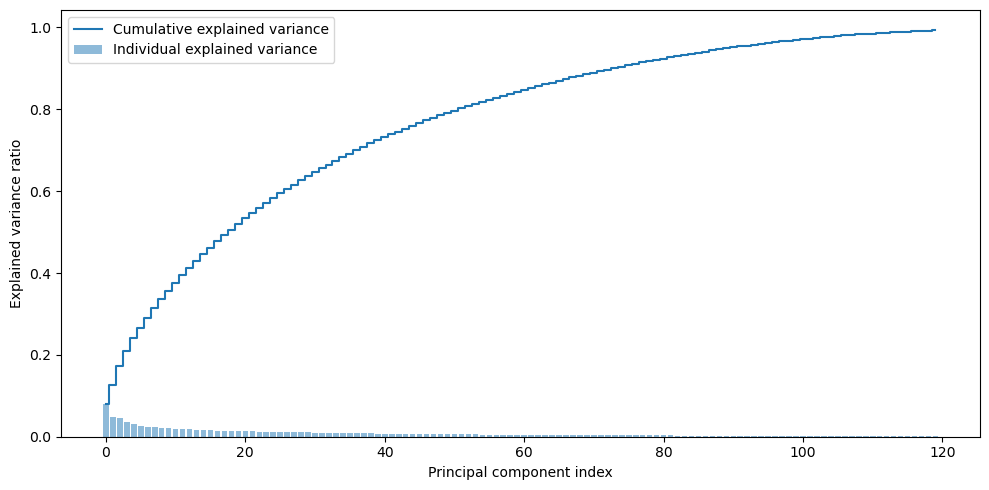

In [61]:
pc_num=120 #This controls how many PC you want to keep

ppl_pca=PCA(n_components=pc_num).fit(descriptor_df_X_scaled_varianced_correlated)
descriptor_df_X_scaled_varianced_correlated_pca=PCA(n_components=pc_num).fit_transform(descriptor_df_X_scaled_varianced_correlated)

ppl_pca_explain_variance=ppl_pca.explained_variance_ratio_
cum_sum_eigenvalues = ppl_pca_explain_variance.cumsum()

print('Overall variance captured by the 1st',pc_num,'PCs is',cum_sum_eigenvalues[pc_num-1]) #pc_num-1 to ensure you don't go over the index of the list cum_sum_eigenvalues

plt.figure(figsize=(10, 5),dpi=100)
plt.bar(range(0,len(ppl_pca_explain_variance)), ppl_pca_explain_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Hyperparameter tunning 
* 10-fold cross-validation

In [62]:
svm_clf=svm.SVC(kernel='rbf',
                class_weight='balanced',
                random_state=0) #rbf kernel was used in the literature Radial Basis Function Kernel The Radial basis function kernel is a popular kernel function commonly used in support vector machine classification. RBF can map an input space in infinite dimensional space

svm_C_gamma_test_step=0.25 #Use 0.25 here if you want to have the same C and gamma lists as the literature
C_list=[] #Stores list of C. The range is determined by the literature
C_initial=-5
for idx in range(81): #Use range(81) here if you want to have the same C list as the literature
  C_list.append(2**C_initial)
  C_initial+=svm_C_gamma_test_step
  if C_initial>15: #This is the max for C in the original literature
    break

gamma_list=[] #Stores list of gamma. The range is determined by the literature
gamma_initial=-19
for idx in range(89): #Use range(89) here if you want to have the same gamma list as the literature 
  gamma_list.append(2**gamma_initial)
  gamma_initial+=svm_C_gamma_test_step
  if gamma_initial>3: #This is the max for gamma in the original literature
    break

svm_param_grid={'C':C_list, #Regularization parameter
                'gamma':gamma_list #Kernel coefficient
                }


svm_clf_grid_search=GridSearchCV(svm_clf,svm_param_grid,
                                 cv=RepeatedStratifiedKFold(n_splits=10, #For a 10-fold cross_validation. This is the number to specify the number of folds in a (Stratified)KFold
                                                           n_repeats=3, #10-fold cross-validation is applied 3 times fitting and evaluating 30 models on the dataset
                                                           random_state=0),
                                 n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 scoring = {'Sensitivity':'recall',
                                            'Specificity':make_scorer(recall_score,pos_label=0), #Default for make_scorer(recall_score) is sensitivity with pos_label=1. pos_label=0 gives specificity
                                            'Precision':'precision',
                                            # 'Accuracy':'accuracy',
                                            'Balanced accuracy':'balanced_accuracy',
                                            'AUC':'roc_auc',
                                            'MCC':make_scorer(matthews_corrcoef)},
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 

svm_clf_grid_search.fit(descriptor_df_X_scaled_varianced_correlated_pca,descriptor_df_y)

dump_pickle(svm_clf_grid_search,'svm GridSearchCV results.pkl') #Save the GridSearchCV object to be used later

In [63]:
ppl_svm_output_df=pd.DataFrame(svm_clf_grid_search.cv_results_) #Generate the output result df
#This is the output in a format of df. The entry with the score you use to refit = 1 is the best hyperparameter set for the model
#If you want to get the top several models for the meta learner, just use 'rank_test_score' to select. The column rank_test_score is unique for each row

In [64]:
ppl_svm_output_df.drop(list(ppl_svm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
print(ppl_svm_output_df.columns)
ppl_svm_output_df.sort_values(by='rank_test_AUC').head() #Shows the top 5 best hyperparameter sets

Index(['param_C', 'param_gamma', 'params', 'mean_test_Sensitivity',
       'rank_test_Sensitivity', 'mean_test_Specificity',
       'rank_test_Specificity', 'mean_test_Precision', 'rank_test_Precision',
       'mean_test_Balanced accuracy', 'rank_test_Balanced accuracy',
       'mean_test_AUC', 'rank_test_AUC', 'mean_test_MCC', 'rank_test_MCC'],
      dtype='object')


,param_C,param_gamma,params,mean_test_Sensitivity,rank_test_Sensitivity,mean_test_Specificity,rank_test_Specificity,mean_test_Precision,rank_test_Precision,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUC,rank_test_AUC,mean_test_MCC,rank_test_MCC
2084,1.681793,0.001161,"{'C': 1.681792830507429, 'gamma': 0.0011613350...",0.776852,5129,0.767460,1956,0.813409,1302,0.772156,859,0.869533,1,0.550425,884
2083,1.681793,0.000977,"{'C': 1.681792830507429, 'gamma': 0.0009765625}",0.793519,4627,0.767460,1956,0.817404,1211,0.780489,529,0.868860,2,0.569802,529
1907,1.189207,0.001381,"{'C': 1.189207115002721, 'gamma': 0.0013810679...",0.777315,5089,0.797619,1760,0.835949,907,0.787467,354,0.868496,3,0.581960,368
2171,2.0,0.000821,"{'C': 2.0, 'gamma': 0.0008211879055212056}",0.793519,4627,0.752381,2251,0.807417,1428,0.772950,846,0.868386,4,0.555062,849
1995,1.414214,0.001161,"{'C': 1.4142135623730951, 'gamma': 0.001161335...",0.789352,4897,0.781746,1902,0.828700,980,0.785549,383,0.868342,5,0.580272,378


In [65]:
print('The best estimator is',svm_clf_grid_search.best_estimator_) #You can directly use this model later
print('The best parameters are',svm_clf_grid_search.best_params_) #Return the parameter setting that gave the best results on the hold out data in the format of a dict
print('The best mean cross-validated score of the best_estimator is',svm_clf_grid_search.best_score_) #best_score_ returns the default score function of the estimator. In the case of SVM, this is the the mean accuracy. But since I put refit='AUC', the best_score_ here is AUC

The best estimator is SVC(C=1.681792830507429, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0011613350732448448, kernel='rbf', max_iter=-1, probability=False,
    random_state=0, shrinking=True, tol=0.001, verbose=False)
The best parameters are {'C': 1.681792830507429, 'gamma': 0.0011613350732448448}
The best mean cross-validated score of the best_estimator is 0.8695326278659611


## Random forest (RF) training
* RF doesn't need scaling on the df
* RF uses bagging as the ensemble method

### Hyperparameter tunning 
* 10-fold cross-validation

In [66]:
rf_clf=RandomForestClassifier(class_weight='balanced', #Because the dataset is slightly imbalanced
                              random_state=0) 
#The generalization error for forests converges as the number of trees in the forest become large. You can pick a large number of tress since our computation time is not limiting (because our data is very small)
#If you want to see how much time remains, add verbose=1 to the model line. I took it out since the output is too much

rf_param_grid={'n_estimators':list(range(1,1001,100)), #The later literature used 1000 trees
               'criterion': ['gini', 'entropy'], 
               'max_features':list(range(1,51,1)) #'max_features':list(range(1,51,1)) is from the literature
               } 
# len(list(ParameterGrid(rf_param_grid)))

rf_clf_grid_search=GridSearchCV(rf_clf, rf_param_grid,
                                cv=RepeatedStratifiedKFold(n_splits=10, #For a 10-fold cross_validation. This is the number to specify the number of folds in a (Stratified)KFold
                                                           n_repeats=3, #10-fold cross-validation is applied 3 times fitting and evaluating 30 models on the dataset
                                                           random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring = {'Sensitivity':'recall',
                                           'Specificity':make_scorer(recall_score,pos_label=0), #Default for make_scorer(recall_score) is sensitivity with pos_label=1. pos_label=0 gives specificity
                                           'Precision':'precision',
                                          #  'Accuracy':'accuracy',
                                           'Balanced accuracy':'balanced_accuracy',
                                           'AUC':'roc_auc',
                                           'MCC':make_scorer(matthews_corrcoef)},
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 


rf_clf_grid_search.fit(descriptor_df_X,descriptor_df_y)

dump_pickle(rf_clf_grid_search,'rf GridSearchCV results.pkl')

In [67]:
ppl_RF_output_df=pd.DataFrame(rf_clf_grid_search.cv_results_) #Generate the output result df
#This is the output in a format of df. The entry with the score you use to refit = 1 is the best hyperparameter set for the model
#If you want to get the top several models for the meta learner, just use 'rank_test_score' to select. The column rank_test_score is unique for each row


In [68]:
ppl_RF_output_df.drop(list(ppl_RF_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
print(ppl_RF_output_df.columns)
ppl_RF_output_df.sort_values(by='rank_test_AUC').head() #Shows the top 5 best hyperparameter sets

Index(['param_criterion', 'param_max_features', 'param_n_estimators', 'params',
       'mean_test_Sensitivity', 'rank_test_Sensitivity',
       'mean_test_Specificity', 'rank_test_Specificity', 'mean_test_Precision',
       'rank_test_Precision', 'mean_test_Balanced accuracy',
       'rank_test_Balanced accuracy', 'mean_test_AUC', 'rank_test_AUC',
       'mean_test_MCC', 'rank_test_MCC'],
      dtype='object')


,param_criterion,param_max_features,param_n_estimators,params,mean_test_Sensitivity,rank_test_Sensitivity,mean_test_Specificity,rank_test_Specificity,mean_test_Precision,rank_test_Precision,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUC,rank_test_AUC,mean_test_MCC,rank_test_MCC
521,entropy,3,101,"{'criterion': 'entropy', 'max_features': 3, 'n...",0.834722,24,0.735714,275,0.805654,59,0.785218,2,0.880969,1,0.589930,2
132,gini,14,201,"{'criterion': 'gini', 'max_features': 14, 'n_e...",0.813889,96,0.733333,280,0.800297,190,0.773611,68,0.880208,2,0.563008,56
21,gini,3,101,"{'criterion': 'gini', 'max_features': 3, 'n_es...",0.842593,6,0.715079,807,0.797251,324,0.778836,13,0.879376,3,0.577923,6
523,entropy,3,301,"{'criterion': 'entropy', 'max_features': 3, 'n...",0.829630,41,0.730952,409,0.802618,128,0.780291,7,0.878549,4,0.576976,8
133,gini,14,301,"{'criterion': 'gini', 'max_features': 14, 'n_e...",0.809259,185,0.747619,37,0.807483,40,0.778439,16,0.878009,5,0.571212,20


In [69]:
print('The best estimator is',rf_clf_grid_search.best_estimator_) #You can directly use this model later
print('The best parameters are',rf_clf_grid_search.best_params_) #Return the parameter setting that gave the best results on the hold out data in the format of a dict
print('The best mean cross-validated score of the best_estimator is',rf_clf_grid_search.best_score_) #best_score_ returns the default score function of the estimator. In the case of RF, this is the the mean accuracy. But since I put refit='AUC', the best_score_ here is AUC

The best estimator is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=101,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
The best parameters are {'criterion': 'entropy', 'max_features': 3, 'n_estimators': 101}
The best mean cross-validated score of the best_estimator is 0.8809689153439154


### Output feature importances

<ipython-input-70-495a1f55d712>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sorted_non_zero_feature_names[:top], fontsize=12)


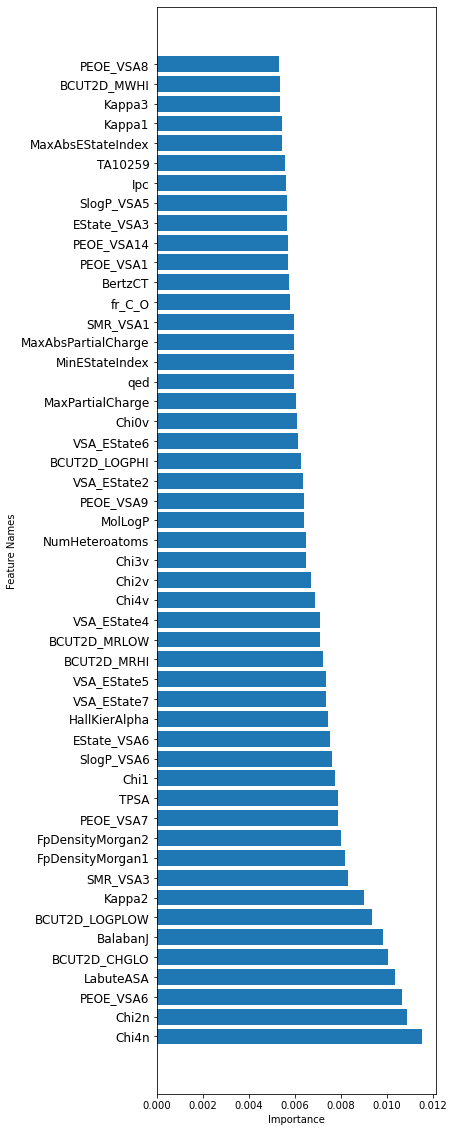

In [70]:
ppl_rf_importance=rf_clf_grid_search.best_estimator_.feature_importances_.copy()
non_zero_index_list = [i for i, v in enumerate(ppl_rf_importance) if v != 0]

# Remove all zero value entries
feature_names=descriptor_df_X.columns
non_zero_feature_names = [feature_names[i] for i in non_zero_index_list]
non_zero_importance = [ppl_rf_importance[i] for i in non_zero_index_list]

# Rank the feature names based on the importance
non_zero_feature_importance=dict(zip(non_zero_feature_names, non_zero_importance))
sorted_non_zero_feature_names=sorted(non_zero_feature_importance, key=non_zero_feature_importance.get, reverse=True) #All the keys have been sorted from the largest to the smallest based on the importance
sorted_non_zero_importance=[non_zero_feature_importance[feature_name] for feature_name in sorted_non_zero_feature_names]

# Plot the feature importance 
top = 50 #This is the number for how many top features you want to see in the plot
fig,ax = plt.subplots(figsize=(5,20))
plt.barh(sorted_non_zero_feature_names[:top], sorted_non_zero_importance[:top])
ax.set_yticklabels(sorted_non_zero_feature_names[:top], fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.show()

## Gradient boosted machine (GBM) training
* Gradient boosted decision trees (GBDT) using decision trees as weak learners; usually outperforms RF
  * It's DT-based so it doesn't need scaling on the data 
* It runs very slowly

### Hyperparameter tunning

In [71]:
gbm_clf=GradientBoostingClassifier(random_state=0) 

gbm_param_grid={'learning_rate':[0.001,0.01,0.1], #Literature used [0.001,0.01,0.1]. Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators. Default is 0.1. Lowering will slow down the learning
                'max_depth':list(range(5,26,5)), #Literature used list(range(5,26,5). The maximum depth of the individual regression estimators or the tree complexity
                'n_estimators':[50,100,500] #Literature used [50,100,500]. The number of trees (default is 100). Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
               } # len(list(ParameterGrid(RF_param_grid)))

gbm_clf_grid_search=GridSearchCV(gbm_clf, gbm_param_grid,
                                cv=RepeatedStratifiedKFold(n_splits=10, #For a 10-fold cross_validation. This is the number to specify the number of folds in a (Stratified)KFold
                                                           n_repeats=3, #10-fold cross-validation is applied 3 times fitting and evaluating 30 models on the dataset
                                                           random_state=0),
                                n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                scoring = {'Sensitivity':'recall',
                                           'Specificity':make_scorer(recall_score,pos_label=0), #Default for make_scorer(recall_score) is sensitivity with pos_label=1. pos_label=0 gives specificity
                                           'Precision':'precision',
                                          #  'Accuracy':'accuracy',
                                           'Balanced accuracy':'balanced_accuracy',
                                           'AUC':'roc_auc',
                                           'MCC':make_scorer(matthews_corrcoef)},
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 


gbm_clf_grid_search.fit(descriptor_df_X,descriptor_df_y)

dump_pickle(gbm_clf_grid_search,'gbm GridSearchCV results.pkl')

In [72]:
ppl_gbm_output_df=pd.DataFrame(gbm_clf_grid_search.cv_results_) #Generate the output result df
#This is the output in a format of df. The entry with the score you use to refit = 1 is the best hyperparameter set for the model
#If you want to get the top several models for the meta learner, just use 'rank_test_score' to select. The column rank_test_score is unique for each row


In [73]:
ppl_gbm_output_df.drop(list(ppl_gbm_output_df.filter(regex = 'time|split|std')), axis = 1, inplace = True) #Remove all the columns with 'time' or 'split' or 'std' since I care more about the meta evaluation results
print(ppl_gbm_output_df.columns)
ppl_gbm_output_df.sort_values(by='rank_test_AUC').head() #Shows the top 5 best hyperparameter sets

Index(['param_learning_rate', 'param_max_depth', 'param_n_estimators',
       'params', 'mean_test_Sensitivity', 'rank_test_Sensitivity',
       'mean_test_Specificity', 'rank_test_Specificity', 'mean_test_Precision',
       'rank_test_Precision', 'mean_test_Balanced accuracy',
       'rank_test_Balanced accuracy', 'mean_test_AUC', 'rank_test_AUC',
       'mean_test_MCC', 'rank_test_MCC'],
      dtype='object')


,param_learning_rate,param_max_depth,param_n_estimators,params,mean_test_Sensitivity,rank_test_Sensitivity,mean_test_Specificity,rank_test_Specificity,mean_test_Precision,rank_test_Precision,mean_test_Balanced accuracy,rank_test_Balanced accuracy,mean_test_AUC,rank_test_AUC,mean_test_MCC,rank_test_MCC
31,0.1,5,100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.743981,16,0.624603,10,0.716069,11,0.684292,2,0.781944,1,0.389254,2
32,0.1,5,500,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.743981,16,0.624603,10,0.716069,11,0.684292,2,0.781944,1,0.389254,2
43,0.1,25,100,"{'learning_rate': 0.1, 'max_depth': 25, 'n_est...",0.724074,38,0.634921,2,0.718890,2,0.679497,5,0.776565,3,0.368350,5
34,0.1,10,100,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.724074,38,0.634921,2,0.718890,2,0.679497,5,0.776565,3,0.368350,5
35,0.1,10,500,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.724074,38,0.634921,2,0.718890,2,0.679497,5,0.776565,3,0.368350,5


In [74]:
print('The best estimator is',gbm_clf_grid_search.best_estimator_) #You can directly use this model later
print('The best parameters are',gbm_clf_grid_search.best_params_) #Return the parameter setting that gave the best results on the hold out data in the format of a dict
print('The best mean cross-validated score of the best_estimator is',gbm_clf_grid_search.best_score_) #best_score_ returns the default score function of the estimator. In the case of SVM, this is the the mean accuracy. But since I put refit='AUC', the best_score_ here is AUC

The best estimator is GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
The best parameters are {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
The best mean cross-validated score of the best_estimator is 0.7819444444444447


### Output feature importances

<ipython-input-75-c3dce22fcbdf>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sorted_non_zero_feature_names[:top], fontsize=12)


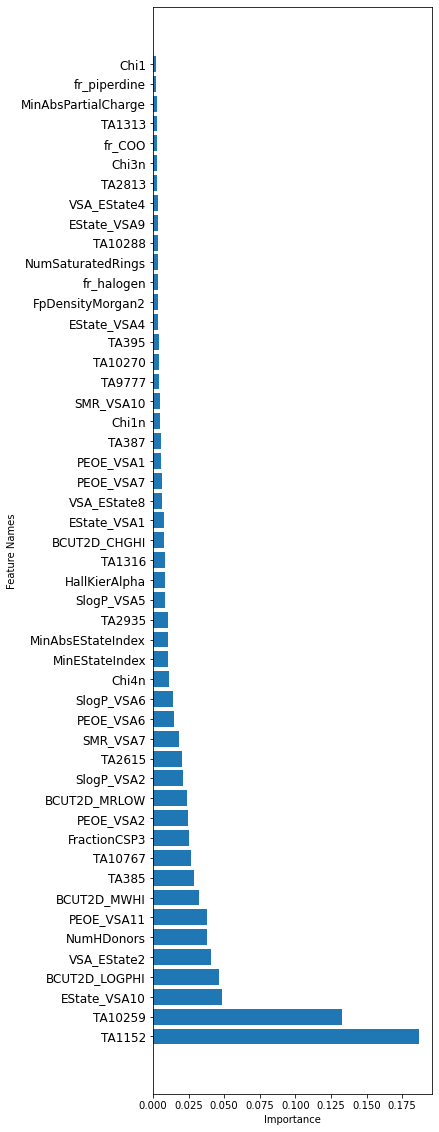

In [75]:
ppl_gbm_importance=gbm_clf_grid_search.best_estimator_.feature_importances_.copy()
non_zero_index_list = [i for i, v in enumerate(ppl_gbm_importance) if v != 0]

# Remove all zero value entries
feature_names=descriptor_df_X.columns
non_zero_feature_names = [feature_names[i] for i in non_zero_index_list]
non_zero_importance = [ppl_gbm_importance[i] for i in non_zero_index_list]

# Rank the feature names based on the importance
non_zero_feature_importance=dict(zip(non_zero_feature_names, non_zero_importance))
sorted_non_zero_feature_names=sorted(non_zero_feature_importance, key=non_zero_feature_importance.get, reverse=True) #All the keys have been sorted from the largest to the smallest based on the importance
sorted_non_zero_importance=[non_zero_feature_importance[feature_name] for feature_name in sorted_non_zero_feature_names]

# Plot the feature importance 
top = 50 #This is the number for how many top features you want to see in the plot
fig,ax = plt.subplots(figsize=(5,20))
plt.barh(sorted_non_zero_feature_names[:top], sorted_non_zero_importance[:top])
ax.set_yticklabels(sorted_non_zero_feature_names[:top], fontsize=12)
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.show()

## Meta stacking RF learner training
* Ensemble based systems can be useful when dealing with large volumes of data or lack of adequate data.

### Reload all the base learners 

In [76]:
#Comparision of the top 2 models of the 3 types of models. If one is significantly better than the other one in all the metrics, then probably exclude that model

ppl_grid_pickle_url_dict={'svm':'https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/GridSearchResults/svm%20GridSearchCV.pkl',
                          'rf':'https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/GridSearchResults/rf%20GridSearchCV.pkl',
                          'gbm':'https://github.com/junqilu/AntiSARSCoV2Prediction/blob/main/PhospholipidosisPrediction/GridSearchResults/gbm%20GridSearchCV.pkl'}

ppl_ranking_standard='rank_test_AUC'

ppl_winners_list=[]
top_models_pick=2 #Only the top 1 best models for each type will be used. I tried pick the top 2 best but for the same model types, the 2 models' predictions are exactly the same
for model_type,pickle_url in ppl_grid_pickle_url_dict.items():
  temp_GridSearchCV=load_cloud_pickle(pickle_url)
  
  #Have a quick peek on the winning models
  temp_output_df=pd.DataFrame(temp_GridSearchCV.cv_results_)
  temp_df=temp_output_df.drop(list(temp_output_df.filter(regex = 'time|split|std')), axis = 1)

  winners_df=temp_df.sort_values(by=ppl_ranking_standard).head(top_models_pick) 
  display(winners_df) #Have a peek on the winner models 

  #Obtain the winning models in a dictionary
  for model_idx in list(range(top_models_pick)): 
    
      
      temp_model_params=temp_output_df.loc[winners_df.index[model_idx], 'params'] #Obtains the params 

      temp_model=clone(temp_GridSearchCV.best_estimator_.set_params(**temp_model_params)) #Set the params for to get the model. You must use the clone() here; otherwise the parameter changing from the 2nd model will also chnage the 1st model, although it's in a tuple 
      
      model_pair=(model_type+'_'+str(model_idx),temp_model)
      ppl_winners_list.append(model_pair) #Collect the model in the dict
    

print(ppl_winners_list) #ppl_winners_dict is a collection of all the base learners

HTTPError: HTTP Error 404: Not Found

### Generate predictions 
* Also make a df for the meta learner

In [ ]:
base_learners_pred_dict={}
for model_id,model in ppl_winners_list:
  if 'svm' in model_id: #Distinguish SVM here since it uses the scaled features
    pred=model.fit(descriptor_df_X_scaled_varianced_correlated_pca,descriptor_df_y).predict(descriptor_df_X_scaled_varianced_correlated_pca)
  else: #Those 4 DT-based models
    pred=model.fit(descriptor_df_X,descriptor_df_y).predict(descriptor_df_X)
  base_learners_pred_dict[model_id]=pred

ppl_base_df=pd.DataFrame(base_learners_pred_dict)
ppl_base_df

In [ ]:
correlation_plot = corrplot.Corrplot(ppl_base_df.corr())
correlation_plot.plot(colorbar=True, method='square', lower='square',shrink=.9 ,rotation=45)

In [ ]:
ppl_meta_df=pd.concat([ppl_base_df, descriptor_df_y], axis=1)
ppl_meta_df

### Hyperparameter tunning 

In [ ]:
meta_rf_clf=RandomForestClassifier(class_weight='balanced', #Because the dataset is slightly imbalanced
                              random_state=0) 
#The generalization error for forests converges as the number of trees in the forest become large. You can pick a large number of tress since our computation time is not limiting (because our data is very small)
#If you want to see how much time remains, add verbose=1 to the model line. I took it out since the output is too much

meta_rf_param_grid={'n_estimators':list(range(1,501,100)), #The later literature used 1000 trees
                    'criterion': ['gini', 'entropy'], 
                    'max_features':list(range(1,5)) 
                    } 
# len(list(ParameterGrid(rf_param_grid)))

meta_rf_clf_grid_search=GridSearchCV(meta_rf_clf, meta_rf_param_grid,
                                cv=RepeatedStratifiedKFold(n_splits=10, #For a 10-fold cross_validation. This is the number to specify the number of folds in a (Stratified)KFold
                                                           n_repeats=3, #10-fold cross-validation is applied 3 times fitting and evaluating 30 models on the dataset
                                                           random_state=0),
                                # n_jobs=-1, #Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                #Somehow if I have the n_jobs=-1 for the step above, I will have the failed to un-serialize error

                                scoring = {'Sensitivity':'recall',
                                           'Specificity':make_scorer(recall_score,pos_label=0), #Default for make_scorer(recall_score) is sensitivity with pos_label=1. pos_label=0 gives specificity
                                           'Precision':'precision',
                                          #  'Accuracy':'accuracy',
                                           'Balanced accuracy':'balanced_accuracy',
                                           'AUC':'roc_auc',
                                           'MCC':make_scorer(matthews_corrcoef)},
                                refit='AUC' #For multiple metric evaluation, refit needs to be a str denoting the scorer that would be used to find the best parameters for refitting the estimator at the end.
                                ) 


meta_rf_clf_grid_search.fit(ppl_base_df,descriptor_df_y)

In [ ]:
print('The best estimator is',meta_rf_clf_grid_search.best_estimator_) #You can directly use this model later
print('The best parameters are',meta_rf_clf_grid_search.best_params_) #Return the parameter setting that gave the best results on the hold out data in the format of a dict
print('The best mean cross-validated score of the best_estimator is',meta_rf_clf_grid_search.best_score_) #best_score_ returns the default score function of the estimator. In the case of SVM, this is the the mean accuracy. But since I put refit='AUC', the best_score_ here is AUC

### Performance on the held-out test set

In [ ]:
ppl_y_predict=meta_rf_clf_grid_search.best_estimator_.predict(ppl_X_test)

print('Recall of the meta learner on held-out test set is',recall_score(ppl_y_test, ppl_y_predict))
print('AUC of the meta learner on held-out test set is',roc_auc_score(ppl_y_test, ppl_y_predict))
print('MCC of the meta learner on held-out test set is',matthews_corrcoef(ppl_y_test, ppl_y_predict))

# Phospholipidosis inducing tendency prediction on the anti-SARS-CoV-2 predictions

# External tools, data sources, and references 
* Open Babel: http://www.cheminfo.org/Chemistry/Cheminformatics/FormatConverter/index.html 
  * Convert different file formats for chemicals' structures
* ToxAlerts: A Web Server of Structural Alerts http://ochem.eu/alerts 
  * Registered users work better 
  * This provides part of the phospholipidosis descriptors (Structural Alerts for potential toxicology in vivo)
* Ensemble learning 
  * A Gentle Introduction to Ensemble Learning Algorithms: https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/ 
  * Advanced Ensemble Learning technique – Stacking and its Variants: https://www.analyticsvidhya.com/blog/2021/03/advanced-ensemble-learning-technique-stacking-and-its-variants/

